<a href="https://colab.research.google.com/github/taavip/automatic-control-of-electrical-equipment-basis-of-price/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

#-----------------------


from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.model_selection import *



In [158]:
def get_tabel():
  url = ('https://dashboard.elering.ee/api/nps/price?start='+str((datetime.now() + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%Y-%m-%d %H:%M"))+'&end='+str((datetime.now() + timedelta(hours=36)).date().strftime("%Y-%m-%d %H:%M")))

  response = requests.get(url).json()

  ep=pd.json_normalize(response['data']['ee'])
  ep['datetime'] = pd.to_datetime(ep['timestamp'], unit='s')
  ep.datetime = ep.datetime.dt.tz_localize('UTC').dt.tz_convert('Europe/Tallinn')
  ep['dow'] = pd.to_datetime(ep['timestamp'], unit='s').dt.dayofweek
  ep['hour'] = pd.to_datetime(ep['timestamp'], unit='s').dt.hour
  ep['week'] = pd.to_datetime(ep['timestamp'], unit='s').dt.isocalendar().week

  url=("http://ohuseire.ee/station/csv?filter%5BstationId%5D=36&filter%5BdateFrom%5D="+str((datetime.now() + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%d.%m.%Y"))+"&filter%5BdateUntil%5D="+str((datetime.now() ).date().strftime("%d.%m.%Y")))

  s=requests.get(url).content
  c=pd.read_csv(io.StringIO(s.decode('utf-8')), sep=';' )

  c['timestamp'] = (pd.to_datetime(c["Kuupäev"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
  d = c[["WD10",'timestamp']]
  c = c.stack().str.replace(',','.').unstack()
  c["NO2"] = pd.to_numeric(c["NO2"], errors='coerce')
  c["CO"] = pd.to_numeric(c["CO"], errors='coerce')
  c["PM10"] = pd.to_numeric(c["PM10"], errors='coerce')
  c["HUM"] = pd.to_numeric(c["HUM"], errors='coerce')
  c["PM2.5"] = pd.to_numeric(c["PM2.5"], errors='coerce')
  c["TEMP"] = pd.to_numeric(c["TEMP"], errors='coerce')
  c["WS10"] = pd.to_numeric(c["WS10"], errors='coerce')
  c["WD10"] = d["WD10"]
  c['timestamp'] = d['timestamp']
  c= c.drop("Kuupäev",axis=1)

  #pd.merge(c, ep, on=['timestamp'])
  return ep


In [159]:
df = get_tabel()


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype                         
---  ------     --------------  -----                         
 0   timestamp  8783 non-null   int64                         
 1   price      8783 non-null   float64                       
 2   datetime   8783 non-null   datetime64[ns, Europe/Tallinn]
 3   dow        8783 non-null   int64                         
 4   hour       8783 non-null   int64                         
 5   week       8783 non-null   UInt32                        
dtypes: UInt32(1), datetime64[ns, Europe/Tallinn](1), float64(1), int64(3)
memory usage: 386.1 KB


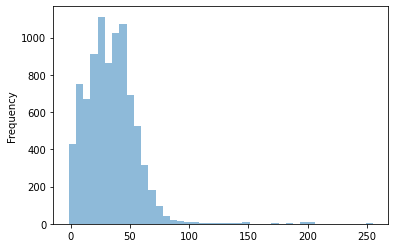

In [161]:
df.price.plot.hist(bins=42, alpha=0.5)

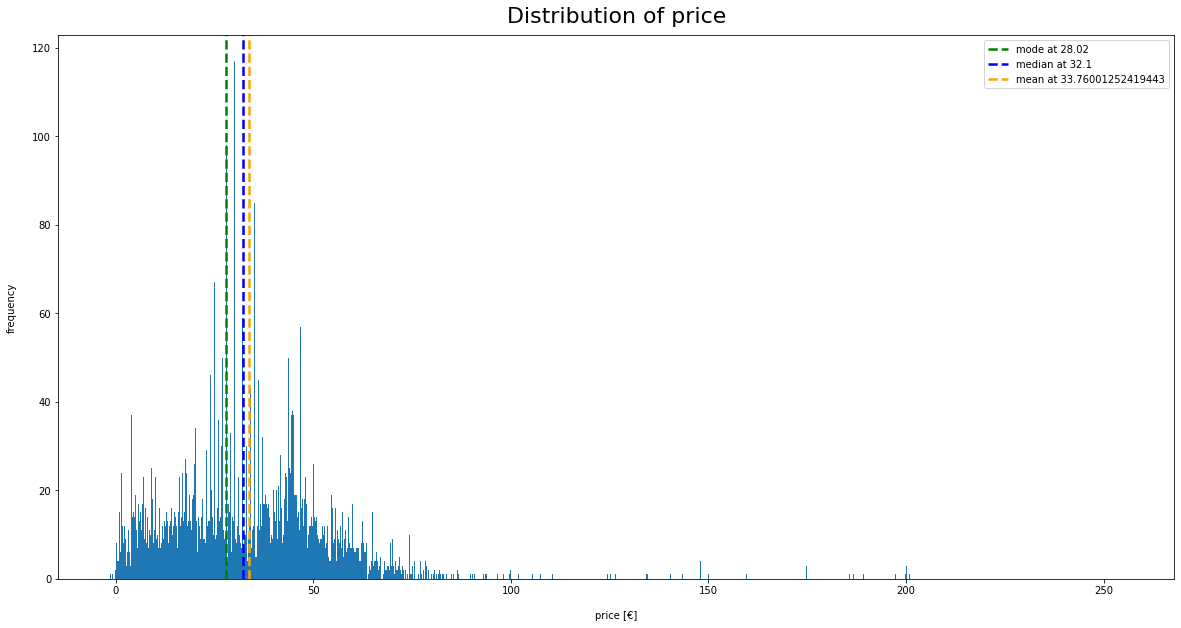

In [162]:
#df['price'].plot(kind='hist', figsize=(10, 8), linewidth=2, color='whitesmoke', edgecolor='gray')
plt.figure(figsize=(20,10))
plt.hist(df['price'], bins=2250 )

plt.xlabel("price [€]", labelpad=15)
plt.ylabel("frequency", labelpad=15)
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of price", y=1.012, fontsize=22)
measurements = [df['price'].mode()[0], df['price'].median(), df['price'].mean()]
names = ["mode", "median", "mean"]
colors = ['green', 'blue', 'orange']
for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
plt.legend();

In [163]:
def nsmall(a, n):
    return np.partition(a, n)[n]

In [164]:
def best_time(df, min, per):
  field=["on_off_"+str(min)+"_"+str(per)]

  df[field] = df.price <= df.price.rolling(window=per,min_periods=per,center=True).apply(lambda x: nsmall(x, min-1))

  #print 
  plot_n(75,field,df)


  return df

In [165]:
def plot_n(n,field,df):
    #print 
  a =df.loc[:,['price','datetime']+field][-n:]
  plt.figure(figsize=(20,10))
  plt.plot(pd.to_datetime(a.datetime), a.price,  marker='x', mec = 'r', markersize=12, markevery=(~a[field]).iloc[:, 0].tolist())
  plt.plot(pd.to_datetime(a.datetime), a.price, linestyle="None", marker='o', c='g', markersize=12, markevery=a[field].iloc[:, 0].tolist())
  plt.grid(b=None, which='major', axis='both')
  plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')

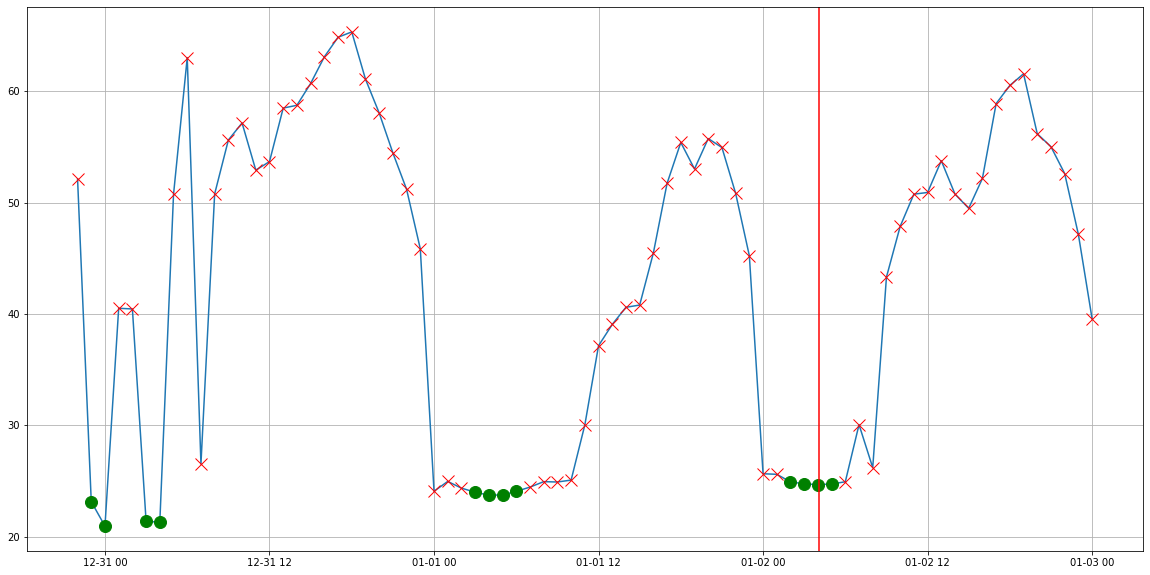

In [166]:
df = best_time(df,4, 24)
#df.tail(50)

In [167]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true+abs(y_true.min()), y_pred+abs(y_true.min()))
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [168]:
data = df.copy()
# creating new dataframe from consumption column
data_consumption = df.copy()
# inserting new column with yesterday's consumption values
#data_consumption.loc[:,'1h'] = data_consumption.loc[:,'price'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
#data_consumption.loc[:,'1h_Diff'] = data_consumption.loc[:,'1h'].diff()

data_consumption['avg24h'] = data_consumption.price.rolling(window=24,min_periods=1).mean()
# dropping NAs
data_consumption = data_consumption.dropna()


In [169]:
num = int(len(data_consumption[:])*0.8)
print(num)
X_train = data_consumption[:num].drop(['price', 'datetime'], axis = 1)
y_train = data_consumption.price[:num]
X_test = data_consumption[num:].drop(['price','datetime'], axis = 1)
y_test = data_consumption.price[num:]

7026


LR: 0.432229 (0.055956)
NN: -0.184014 (0.203120)
KNN: -0.453731 (0.525790)
RF: 0.001019 (1.220594)
SVR: -0.144942 (0.163663)


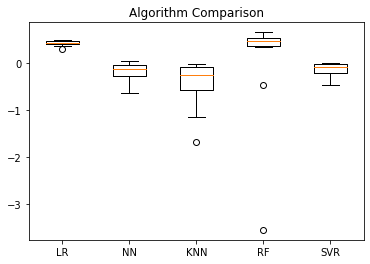

In [170]:


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [171]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


model = RandomForestRegressor()
param_search = { 
    'n_estimators': [ 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(3,11)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [172]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.572
mean_squared_log_error:  0.3741
r2:  0.5681
MAE:  13.2482
MSE:  343.3202
RMSE:  18.5289


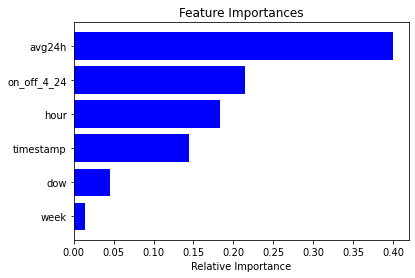

In [173]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

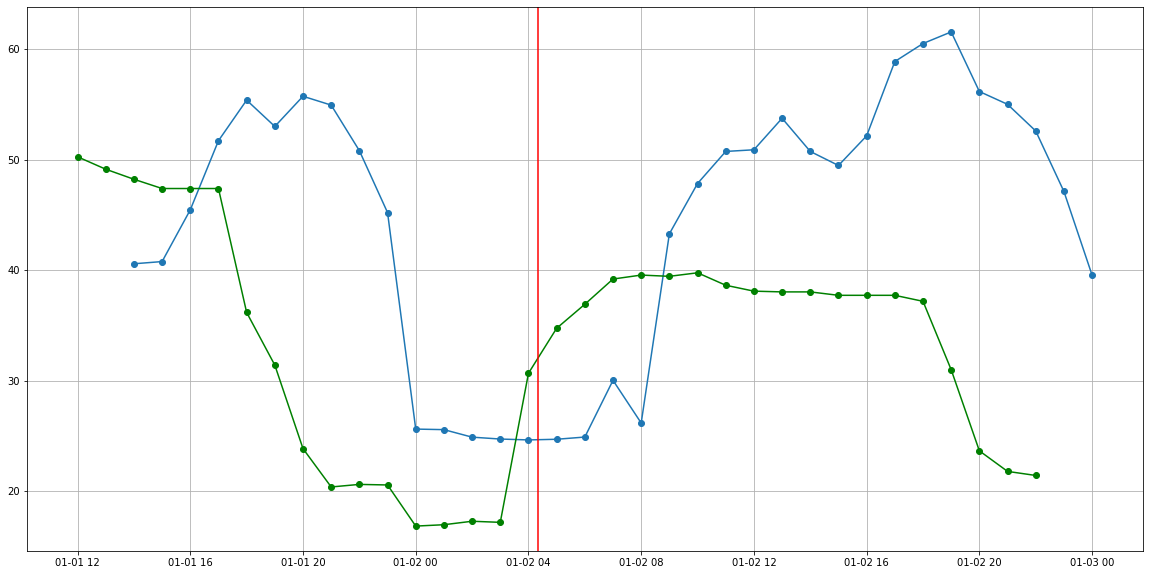

In [175]:
a =df.loc[:,['price','datetime']][-35:]

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(a.datetime), a.price,  marker='o')
plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:],  marker='o',color='green')
#plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:]-a.price,  marker='x',color='cyan')
plt.grid(b=None, which='major', axis='both')
plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')